# Testing Cochlea vs BEZ Regression Workflow

This notebook tests:
1. Data loading (BEZ and Cochlea)
2. Mean rate computation
3. Linear regression at a specific dB level
4. Separate visualization for each fiber type (HSR, MSR, LSR)
5. **BEZ run correlation analysis** - Assess if BEZ runs are consistent enough to average

## Setup: Imports and Paths

In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

from subcorticalSTRF.data_loader import (
    load_bez_psth_data,
    load_matlab_data,
    mean_across_time_psth_bez,
    mean_across_time_psth_cochlea,
    extract_data_at_db,
    match_data_points,
    plot_regression_seaborn_cf_brightness,  # Advanced seaborn plotting
    compute_bez_run_pairwise_correlations,  # BEZ run-to-run correlations
    compute_cochlea_vs_bez_runs_correlations,  # Cochlea vs each BEZ run
    plot_correlation_comparison,  # Visualization of correlation comparisons
    save_correlation_statistics  # Save statistics to JSON/text/LaTeX files
)

# Set output directory for all results
OUTPUT_DIR = 'model_comparison_PSTH_final'
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
print(f"✓ Output directory: {OUTPUT_DIR}")

print("✓ Imports successful")

✓ Imports successful


## Step 1: Load BEZ Data (Individual Runs)

In [3]:
# Load BEZ PSTH data with individual runs
print("Loading BEZ data...")
bez_data, params = load_bez_psth_data()

# The function already prints the details, so we just add a summary
print(f"\n✓ Ready for analysis:")
print(f"   {len(params['cfs'])} CFs × {len(params['frequencies'])} frequencies × {len(params['dbs'])} dB levels × {bez_data['hsr_all'].shape[3]} runs")

Loading BEZ data...
Loading BEZ PSTH data from: /home/ekim/PycharmProjects/phd_firstyear/subcorticalSTRF/BEZ2018_meanrate/results/processed_data/psth_data_128fibers.mat
✓ BEZ PSTH data loaded successfully
Parameters extracted:
  CFs: 20 values
  Frequencies: 20 values
  dB levels: [50. 60. 70. 80.]
Data structure:
  hsr_all shape: (20, 20, 4, 10)
  msr_all shape: (20, 20, 4, 10)
  lsr_all shape: (20, 20, 4, 10)

✓ Ready for analysis:
   20 CFs × 20 frequencies × 4 dB levels × 10 runs
✓ BEZ PSTH data loaded successfully
Parameters extracted:
  CFs: 20 values
  Frequencies: 20 values
  dB levels: [50. 60. 70. 80.]
Data structure:
  hsr_all shape: (20, 20, 4, 10)
  msr_all shape: (20, 20, 4, 10)
  lsr_all shape: (20, 20, 4, 10)

✓ Ready for analysis:
   20 CFs × 20 frequencies × 4 dB levels × 10 runs


## Step 2: Load Cochlea Data

In [4]:
# Try to load cochlea data
print("Loading Cochlea data...")

try:
    # Try the aggregated data loader first
    from scipy.io import loadmat
    
    cochlea_path = Path.cwd() / 'cochlea_meanrate' / 'out' / 'condition_psths' / 'cochlea_psths.mat'
    
    if cochlea_path.exists():
        data = loadmat(str(cochlea_path))
        cochlea_data = {
            'hsr_all': data['hsr_all'],
            'msr_all': data['msr_all'],
            'lsr_all': data['lsr_all']
        }
        print(f"✓ Loaded from {cochlea_path}")
    else:
        print(f"⚠ Cochlea file not found at {cochlea_path}")
        print("Creating synthetic data for testing...")
        # Create synthetic data with same structure as BEZ (but without run dimension)
        cochlea_data = {
            'hsr_all': np.random.rand(20, 20, 4, 128) * 100,  # (CF, freq, dB, time)
            'msr_all': np.random.rand(20, 20, 4, 128) * 100,
            'lsr_all': np.random.rand(20, 20, 4, 128) * 100
        }
except Exception as e:
    print(f"Error loading cochlea: {e}")
    print("Creating synthetic data for testing...")
    cochlea_data = {
        'hsr_all': np.random.rand(20, 20, 4, 128) * 100,
        'msr_all': np.random.rand(20, 20, 4, 128) * 100,
        'lsr_all': np.random.rand(20, 20, 4, 128) * 100
    }

print(f"\nCochlea data shapes:")
print(f"  HSR: {cochlea_data['hsr_all'].shape}  (CF × freq × dB × time)")
print(f"  MSR: {cochlea_data['msr_all'].shape}")
print(f"  LSR: {cochlea_data['lsr_all'].shape}")

Loading Cochlea data...
✓ Loaded from /home/ekim/PycharmProjects/phd_firstyear/subcorticalSTRF/cochlea_meanrate/out/condition_psths/cochlea_psths.mat

Cochlea data shapes:
  HSR: (20, 20, 4)  (CF × freq × dB × time)
  MSR: (20, 20, 4)
  LSR: (20, 20, 4)


## Step 3: Test Mean Rate Computation

Compute mean firing rates across time for both datasets

In [5]:
# Compute mean rates for Cochlea
print("Computing Cochlea mean rates...")
cochlea_means = mean_across_time_psth_cochlea(cochlea_data, params)

print(f"✓ Cochlea means computed")
print(f"  Structure: {type(cochlea_means)}")
print(f"  Fiber types: {list(cochlea_means.keys())}")
print(f"  Example - HSR CFs: {len(cochlea_means['hsr'])}")

# Show a sample
sample_cf = list(cochlea_means['hsr'].keys())[0]
sample_freq = list(cochlea_means['hsr'][sample_cf].keys())[0]
sample_db = list(cochlea_means['hsr'][sample_cf][sample_freq].keys())[0]
print(f"\nSample value (HSR, CF={sample_cf:.1f}, freq={sample_freq:.1f}, dB={sample_db}):")
print(f"  Mean rate = {cochlea_means['hsr'][sample_cf][sample_freq][sample_db]:.2f} spikes/s")

Computing Cochlea mean rates...
Cochlea data dimensions: CFs=20, Freqs=20, dBs=4
 Processing Cochlea hsr fibers...
 Processing Cochlea msr fibers...
 Processing Cochlea lsr fibers...
✓ Cochlea means computed
  Structure: <class 'dict'>
  Fiber types: ['hsr', 'msr', 'lsr']
  Example - HSR CFs: 20

Sample value (HSR, CF=125.0, freq=125.0, dB=50.0):
  Mean rate = 137.97 spikes/s


In [7]:
# Compute mean rates for BEZ
print("Computing BEZ mean rates...")
bez_means = mean_across_time_psth_bez(bez_data, params)

print(f"✓ BEZ means computed")
print(f"  Structure: {type(bez_means)}")
print(f"  Fiber types: {list(bez_means.keys())}")

# Show a sample with runs
sample_cf = list(bez_means['hsr'].keys())[0]
sample_freq = list(bez_means['hsr'][sample_cf].keys())[0]
sample_db = list(bez_means['hsr'][sample_cf][sample_freq].keys())[0]
print(f"\nSample values (HSR, CF={sample_cf:.1f}, freq={sample_freq:.1f}, dB={sample_db}):")
print(f"  Runs: {list(bez_means['hsr'][sample_cf][sample_freq][sample_db].keys())}")
print(f"  Run 0 mean rate = {bez_means['hsr'][sample_cf][sample_freq][sample_db][0]:.2f} spikes/s")
print(f"  Run 1 mean rate = {bez_means['hsr'][sample_cf][sample_freq][sample_db][1]:.2f} spikes/s")

Computing BEZ mean rates...
BEZ data dimensions: CFs=20, Freqs=20, dBs=4, Runs=10
 Processing BEZ hsr fibers...
 Processing BEZ msr fibers...
 Processing BEZ lsr fibers...
✓ BEZ means computed
  Structure: <class 'dict'>
  Fiber types: ['hsr', 'msr', 'lsr']

Sample values (HSR, CF=125.0, freq=125.0, dB=50.0):
  Runs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  Run 0 mean rate = 160.27 spikes/s
  Run 1 mean rate = 157.30 spikes/s
✓ BEZ means computed
  Structure: <class 'dict'>
  Fiber types: ['hsr', 'msr', 'lsr']

Sample values (HSR, CF=125.0, freq=125.0, dB=50.0):
  Runs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  Run 0 mean rate = 160.27 spikes/s
  Run 1 mean rate = 157.30 spikes/s


## Step 4: Select dB Level for Regression

In [8]:
# Choose which dB level to analyze
selected_db = 60.0  # Change this to test different levels: 50, 60, 70, or 80

print(f"Selected dB level: {selected_db}")
print(f"Available dB levels: {params['dbs']}")

# Also select which BEZ run to compare
selected_run = 0  # Run 0 (first run)
print(f"Comparing to BEZ Run: {selected_run}")
print(f"\n⚠️ IMPORTANT: Analysis will be conducted ONLY at {selected_db} dB")
print(f"   Data from other dB levels will be excluded.")

Selected dB level: 60.0
Available dB levels: [50. 60. 70. 80.]
Comparing to BEZ Run: 0

⚠️ IMPORTANT: Analysis will be conducted ONLY at 60.0 dB
   Data from other dB levels will be excluded.


## Step 5: Filter Data to Selected dB Level

Extract ONLY data at the selected dB level (removes other dB levels from analysis)

In [9]:
# Filter both datasets to only include the selected dB level
print(f"Filtering data to {selected_db} dB only...")

cochlea_db = extract_data_at_db(cochlea_means, selected_db)
bez_db = extract_data_at_db(bez_means, selected_db)

print(f"\n✓ Data filtered to {selected_db} dB")
print(f"\nFiltered structure (dB dimension removed):")
print(f"  Cochlea: [fiber_type][cf][freq] = mean_rate")
print(f"  BEZ: [fiber_type][cf][freq][run] = mean_rate")

# Verify the filtering
sample_fiber = 'hsr'
n_cfs_filtered = len(cochlea_db[sample_fiber])
n_freqs_filtered = len(cochlea_db[sample_fiber][list(cochlea_db[sample_fiber].keys())[0]])
print(f"\n  HSR has {n_cfs_filtered} CFs × {n_freqs_filtered} freqs = {n_cfs_filtered * n_freqs_filtered} conditions at {selected_db} dB")

Filtering data to 60.0 dB only...

✓ Data filtered to 60.0 dB

Filtered structure (dB dimension removed):
  Cochlea: [fiber_type][cf][freq] = mean_rate
  BEZ: [fiber_type][cf][freq][run] = mean_rate

  HSR has 20 CFs × 20 freqs = 400 conditions at 60.0 dB


## Step 6: Extract Data Pairs for Regression

Extract matching (Cochlea, BEZ) pairs at the selected dB level for each fiber type

In [10]:
def extract_pairs_at_db(cochlea_db_data, bez_db_data, fiber_type, run_idx):
    """
    Extract (Cochlea, BEZ) pairs for a specific fiber type at a single dB level.
    
    Note: Input data should already be filtered to a single dB level using extract_data_at_db()
    
    Returns:
        cochlea_values: array of cochlea mean rates
        bez_values: array of corresponding BEZ mean rates
    """
    cochlea_vals = []
    bez_vals = []
    
    fiber_cochlea = cochlea_db_data[fiber_type]
    fiber_bez = bez_db_data[fiber_type]
    
    # Iterate through all CF and frequency combinations
    for cf in fiber_cochlea.keys():
        if cf not in fiber_bez:
            continue
            
        for freq in fiber_cochlea[cf].keys():
            if freq not in fiber_bez[cf]:
                continue
            
            # At this point, we're already at the dB level (it was filtered out)
            cochlea_val = fiber_cochlea[cf][freq]
            bez_val = fiber_bez[cf][freq][run_idx]  # BEZ still has run dimension
            
            cochlea_vals.append(cochlea_val)
            bez_vals.append(bez_val)
    
    return np.array(cochlea_vals), np.array(bez_vals)


# Extract data for each fiber type at the selected dB level
print(f"Extracting data pairs at {selected_db} dB...\n")

data_pairs = {}
for fiber in ['hsr', 'msr', 'lsr']:
    cochlea_vals, bez_vals = extract_pairs_at_db(
        cochlea_db, bez_db, fiber, selected_run
    )
    data_pairs[fiber] = (cochlea_vals, bez_vals)
    print(f"{fiber.upper()}: {len(cochlea_vals)} data pairs (at {selected_db} dB only)")
    print(f"  Cochlea range: {cochlea_vals.min():.2f} - {cochlea_vals.max():.2f}")
    print(f"  BEZ range: {bez_vals.min():.2f} - {bez_vals.max():.2f}")
    print()

Extracting data pairs at 60.0 dB...

HSR: 400 data pairs (at 60.0 dB only)
  Cochlea range: 57.19 - 236.09
  BEZ range: 59.96 - 199.73

MSR: 400 data pairs (at 60.0 dB only)
  Cochlea range: 4.96 - 160.59
  BEZ range: 4.57 - 158.09

LSR: 400 data pairs (at 60.0 dB only)
  Cochlea range: 0.16 - 74.41
  BEZ range: 0.08 - 94.22



## Step 7: Compute Linear Regression for Each Fiber Type

Perform regression analysis separately for each fiber type (HSR, MSR, LSR) at the selected dB level

In [11]:
# Compute regression for each fiber type
regression_results = {}

print(f"Linear Regression Results ({selected_db} dB, Run {selected_run})")
print("=" * 70)

for fiber in ['hsr', 'msr', 'lsr']:
    cochlea_vals, bez_vals = data_pairs[fiber]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, stderr = linregress(cochlea_vals, bez_vals)
    
    regression_results[fiber] = {
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'r_squared': r_value**2,
        'p_value': p_value,
        'stderr': stderr
    }
    
    print(f"\n{fiber.upper()}:")
    print(f"  Slope:        {slope:.4f} ± {stderr:.4f}")
    print(f"  Intercept:    {intercept:.4f}")
    print(f"  R²:           {r_value**2:.4f}")
    print(f"  R (Pearson):  {r_value:.4f}")
    print(f"  p-value:      {p_value:.2e}")

print("\n" + "=" * 70)

Linear Regression Results (60.0 dB, Run 0)

HSR:
  Slope:        0.8395 ± 0.0097
  Intercept:    11.3169
  R²:           0.9496
  R (Pearson):  0.9745
  p-value:      3.00e-260

MSR:
  Slope:        1.0823 ± 0.0134
  Intercept:    3.6807
  R²:           0.9427
  R (Pearson):  0.9709
  p-value:      3.11e-249

LSR:
  Slope:        1.4509 ± 0.0086
  Intercept:    0.0985
  R²:           0.9863
  R (Pearson):  0.9931
  p-value:      0.00e+00



## Step 8: Visualize Regression - HSR Fibers

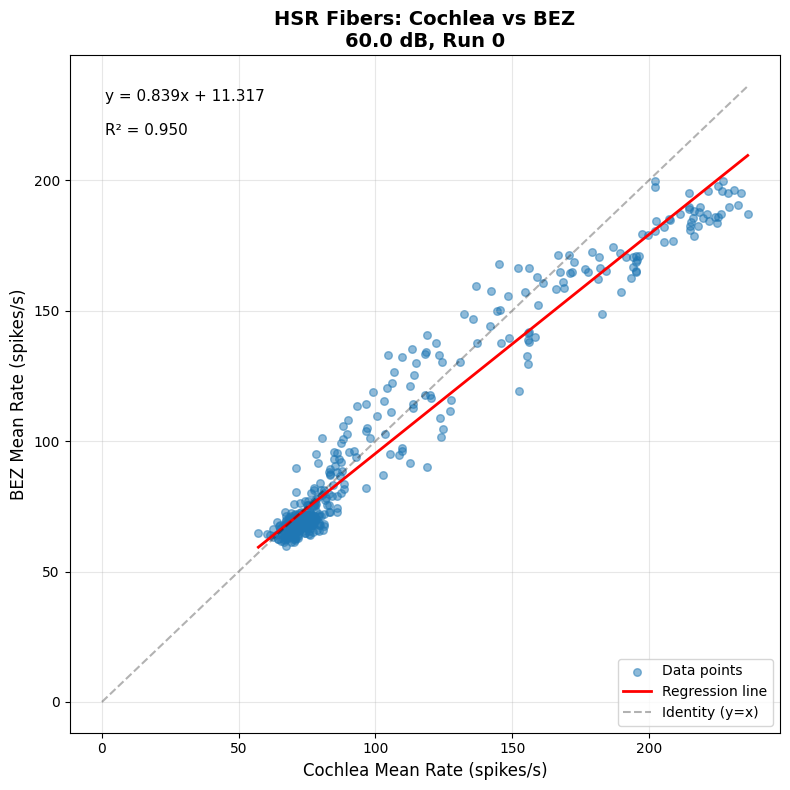


HSR: 400 data points plotted


In [11]:
# Plot HSR regression
fiber = 'hsr'
cochlea_vals, bez_vals = data_pairs[fiber]
result = regression_results[fiber]

fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot
ax.scatter(cochlea_vals, bez_vals, alpha=0.5, s=30, label='Data points')

# Regression line
x_range = np.array([cochlea_vals.min(), cochlea_vals.max()])
y_pred = result['slope'] * x_range + result['intercept']
ax.plot(x_range, y_pred, 'r-', linewidth=2, label='Regression line')

# Identity line (y=x)
max_val = max(cochlea_vals.max(), bez_vals.max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Identity (y=x)')

# Labels and title
ax.set_xlabel('Cochlea Mean Rate (spikes/s)', fontsize=12)
ax.set_ylabel('BEZ Mean Rate (spikes/s)', fontsize=12)
ax.set_title(f'HSR Fibers: Cochlea vs BEZ\n{selected_db} dB, Run {selected_run}', fontsize=14, fontweight='bold')

# Add regression equation and R²
equation = f"y = {result['slope']:.3f}x + {result['intercept']:.3f}"
r_squared_text = f"R² = {result['r_squared']:.3f}"
ax.text(0.05, 0.95, equation, transform=ax.transAxes, fontsize=11, verticalalignment='top')
ax.text(0.05, 0.90, r_squared_text, transform=ax.transAxes, fontsize=11, verticalalignment='top')

ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nHSR: {len(cochlea_vals)} data points plotted")

## Step 9: Visualize Regression - MSR Fibers

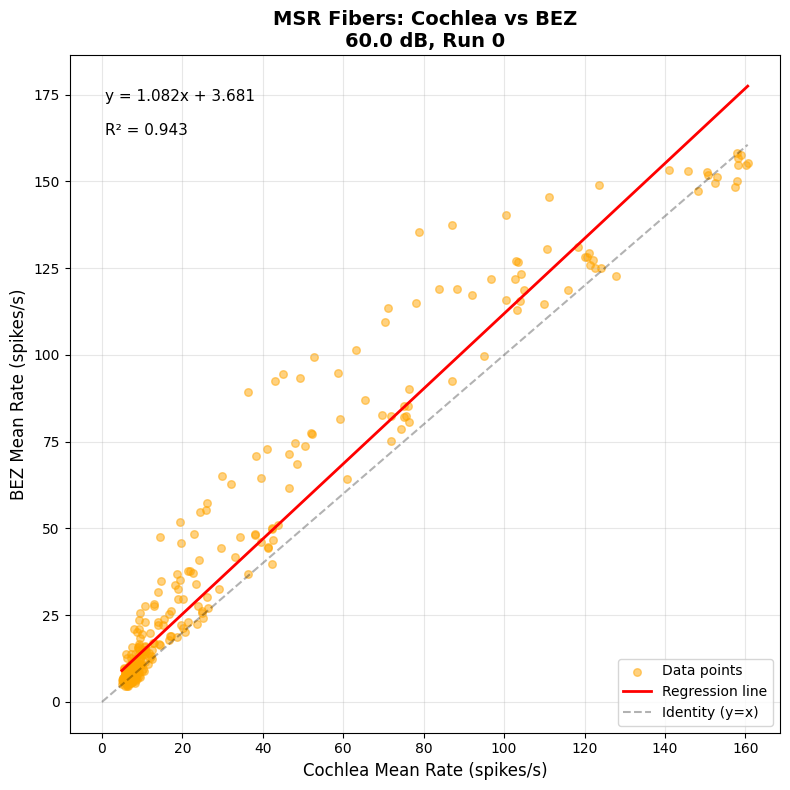


MSR: 400 data points plotted


In [14]:
# Plot MSR regression
fiber = 'msr'
cochlea_vals, bez_vals = data_pairs[fiber]
result = regression_results[fiber]

fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot
ax.scatter(cochlea_vals, bez_vals, alpha=0.5, s=30, label='Data points', color='orange')

# Regression line
x_range = np.array([cochlea_vals.min(), cochlea_vals.max()])
y_pred = result['slope'] * x_range + result['intercept']
ax.plot(x_range, y_pred, 'r-', linewidth=2, label='Regression line')

# Identity line (y=x)
max_val = max(cochlea_vals.max(), bez_vals.max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Identity (y=x)')

# Labels and title
ax.set_xlabel('Cochlea Mean Rate (spikes/s)', fontsize=12)
ax.set_ylabel('BEZ Mean Rate (spikes/s)', fontsize=12)
ax.set_title(f'MSR Fibers: Cochlea vs BEZ\n{selected_db} dB, Run {selected_run}', fontsize=14, fontweight='bold')

# Add regression equation and R²
equation = f"y = {result['slope']:.3f}x + {result['intercept']:.3f}"
r_squared_text = f"R² = {result['r_squared']:.3f}"
ax.text(0.05, 0.95, equation, transform=ax.transAxes, fontsize=11, verticalalignment='top')
ax.text(0.05, 0.90, r_squared_text, transform=ax.transAxes, fontsize=11, verticalalignment='top')

ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMSR: {len(cochlea_vals)} data points plotted")

## Step 10: Visualize Regression - LSR Fibers

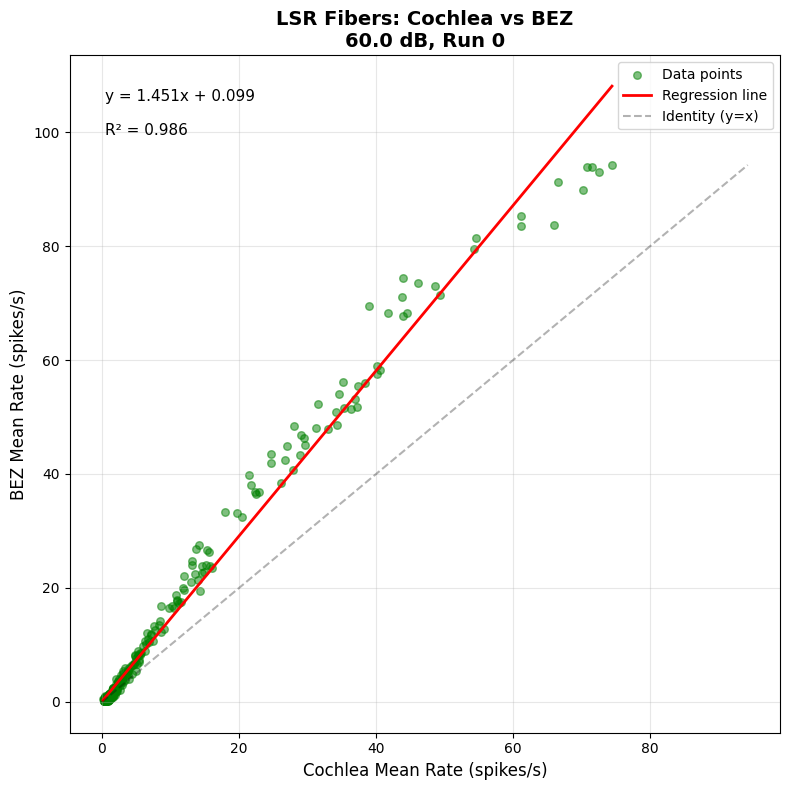


LSR: 400 data points plotted


In [15]:
# Plot LSR regression
fiber = 'lsr'
cochlea_vals, bez_vals = data_pairs[fiber]
result = regression_results[fiber]

fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot
ax.scatter(cochlea_vals, bez_vals, alpha=0.5, s=30, label='Data points', color='green')

# Regression line
x_range = np.array([cochlea_vals.min(), cochlea_vals.max()])
y_pred = result['slope'] * x_range + result['intercept']
ax.plot(x_range, y_pred, 'r-', linewidth=2, label='Regression line')

# Identity line (y=x)
max_val = max(cochlea_vals.max(), bez_vals.max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Identity (y=x)')

# Labels and title
ax.set_xlabel('Cochlea Mean Rate (spikes/s)', fontsize=12)
ax.set_ylabel('BEZ Mean Rate (spikes/s)', fontsize=12)
ax.set_title(f'LSR Fibers: Cochlea vs BEZ\n{selected_db} dB, Run {selected_run}', fontsize=14, fontweight='bold')

# Add regression equation and R²
equation = f"y = {result['slope']:.3f}x + {result['intercept']:.3f}"
r_squared_text = f"R² = {result['r_squared']:.3f}"
ax.text(0.05, 0.95, equation, transform=ax.transAxes, fontsize=11, verticalalignment='top')
ax.text(0.05, 0.90, r_squared_text, transform=ax.transAxes, fontsize=11, verticalalignment='top')

ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nLSR: {len(cochlea_vals)} data points plotted")

## Step 11: Summary Comparison Across Fiber Types

Compare regression results across all three fiber types at the selected dB level

In [16]:
# Create summary table
print(f"\nSummary: Linear Regression at {selected_db} dB (Run {selected_run})")
print("=" * 80)
print(f"{'Fiber':<8} {'N points':<10} {'Slope':<12} {'Intercept':<12} {'R²':<10} {'R (Pearson)'}")
print("=" * 80)

for fiber in ['hsr', 'msr', 'lsr']:
    result = regression_results[fiber]
    n_points = len(data_pairs[fiber][0])
    print(f"{fiber.upper():<8} {n_points:<10} {result['slope']:<12.4f} {result['intercept']:<12.4f} "
          f"{result['r_squared']:<10.4f} {result['r_value']:.4f}")

print("=" * 80)

# Key observations
print("\nKey Observations:")
for fiber in ['hsr', 'msr', 'lsr']:
    result = regression_results[fiber]
    slope = result['slope']
    
    if abs(slope - 1.0) < 0.1:
        interpretation = "close to 1:1 correspondence"
    elif slope > 1.0:
        interpretation = "BEZ rates higher than Cochlea"
    else:
        interpretation = "BEZ rates lower than Cochlea"
    
    print(f"  {fiber.upper()}: Slope = {slope:.3f} → {interpretation}")


Summary: Linear Regression at 60.0 dB (Run 0)
Fiber    N points   Slope        Intercept    R²         R (Pearson)
HSR      400        0.8395       11.3169      0.9496     0.9745
MSR      400        1.0823       3.6807       0.9427     0.9709
LSR      400        1.4509       0.0985       0.9863     0.9931

Key Observations:
  HSR: Slope = 0.839 → BEZ rates lower than Cochlea
  MSR: Slope = 1.082 → close to 1:1 correspondence
  LSR: Slope = 1.451 → BEZ rates higher than Cochlea


## Optional: Analyze Across All dB Levels

To compare how regression results change across dB levels, you can loop through all dB values

In [ ]:
# Example: Analyze each dB level separately
all_db_results = {}

for db_level in params['dbs']:
    print(f"\n{'='*60}")
    print(f"Analyzing {db_level} dB")
    print('='*60)
    
    # Filter to this dB level
    cochlea_db_temp = extract_data_at_db(cochlea_means, db_level)
    bez_db_temp = extract_data_at_db(bez_means, db_level)
    
    # Store results for each fiber type at this dB
    all_db_results[db_level] = {}
    
    for fiber in ['hsr', 'msr', 'lsr']:
        c_vals, b_vals = extract_pairs_at_db(cochlea_db_temp, bez_db_temp, fiber, selected_run)
        
        # Compute regression
        slope, intercept, r_value, p_value, stderr = linregress(c_vals, b_vals)
        
        all_db_results[db_level][fiber] = {
            'slope': slope,
            'r_squared': r_value**2,
            'n_points': len(c_vals)
        }
        
        print(f"  {fiber.upper()}: slope={slope:.3f}, R²={r_value**2:.3f}, N={len(c_vals)}")

# Summary table across dB levels
print(f"\n\n{'='*80}")
print("SUMMARY: Regression Slopes Across dB Levels")
print('='*80)
print(f"{'dB Level':<12} {'HSR Slope':<15} {'MSR Slope':<15} {'LSR Slope':<15}")
print('-'*80)
for db_level in sorted(all_db_results.keys()):
    hsr_slope = all_db_results[db_level]['hsr']['slope']
    msr_slope = all_db_results[db_level]['msr']['slope']
    lsr_slope = all_db_results[db_level]['lsr']['slope']
    print(f"{db_level:<12.1f} {hsr_slope:<15.4f} {msr_slope:<15.4f} {lsr_slope:<15.4f}")
print('='*80)

## Advanced Visualization: Seaborn with CF-Frequency Encoding

Use color (hue) to represent Characteristic Frequency and brightness (alpha) to show distance from CF

Creating advanced seaborn visualization at 60.0 dB...
  • Color (hue) = Characteristic Frequency (perceptually uniform)
  • Brightness (alpha) = Distance from CF (bright = at CF, dim = far from CF)

Creating seaborn plots with 20 CFs at 60.0 dB...
Creating seaborn plots with 20 CFs at 60.0 dB...
  HSR: 400 points, slope=1.131, R²=0.950
  MSR: 400 points, slope=0.871, R²=0.943
  LSR: 400 points, slope=0.680, R²=0.986
  HSR: 400 points, slope=1.131, R²=0.950
  MSR: 400 points, slope=0.871, R²=0.943
  LSR: 400 points, slope=0.680, R²=0.986
✓ Figure saved to: regression_seaborn_cf_brightness_60dB_run0.png
✓ Figure saved to: regression_seaborn_cf_brightness_60dB_run0.png


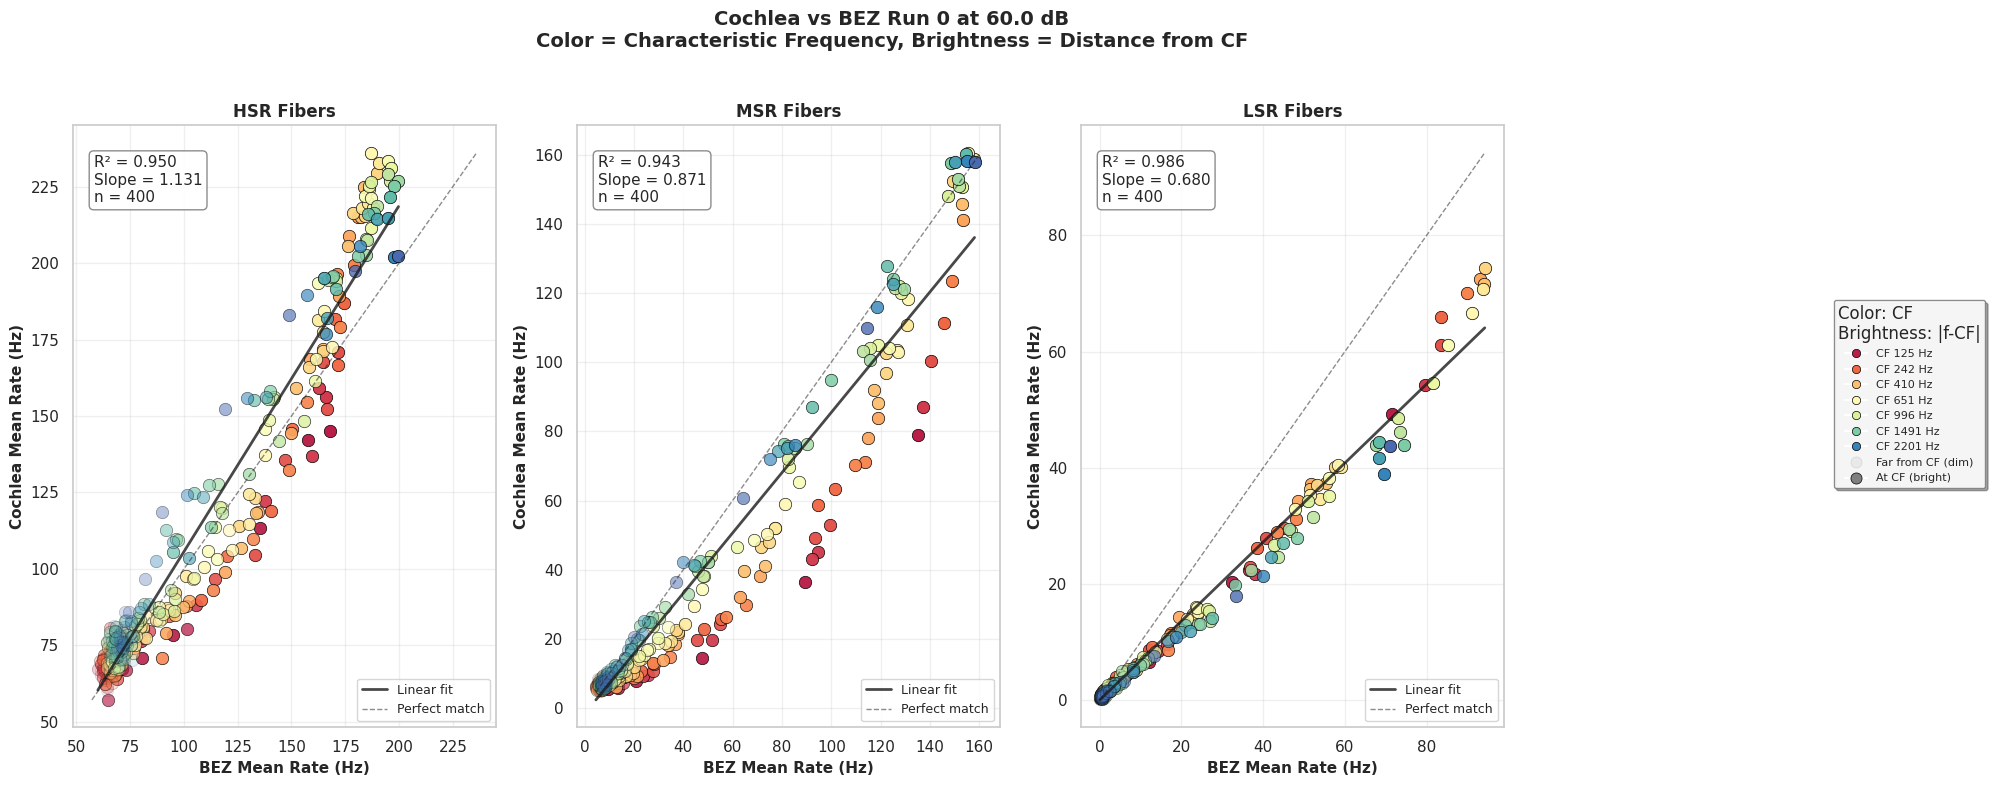


Statistics from Advanced Plot:
HSR: slope=1.131, R²=0.950, p=3.00e-260, n=400
MSR: slope=0.871, R²=0.943, p=3.11e-249, n=400
LSR: slope=0.680, R²=0.986, p=0.00e+00, n=400


In [ ]:
# Import the advanced plotting function
from subcorticalSTRF.data_loader import plot_regression_seaborn_cf_brightness

# Create advanced seaborn plot with CF as hue and frequency difference as brightness
print(f"Creating advanced seaborn visualization at {selected_db} dB...")
print("  • Color (hue) = Characteristic Frequency (perceptually uniform)")
print("  • Brightness (alpha) = Distance from CF (bright = at CF, dim = far from CF)")
print()

fig, axes, stats = plot_regression_seaborn_cf_brightness(
    cochlea_means, 
    bez_means, 
    run_idx=selected_run,
    db_level=selected_db,
    figsize=(18, 8),
    save_path=f'{OUTPUT_DIR}/regression_seaborn_cf_brightness_{int(selected_db)}dB_run{selected_run}.png'
)

plt.show()

# Print statistics
print("\nStatistics from Advanced Plot:")
print("=" * 60)
for fiber in ['hsr', 'msr', 'lsr']:
    if fiber in stats:
        s = stats[fiber]
        print(f"{fiber.upper()}: slope={s['slope']:.3f}, R²={s['r_squared']:.3f}, "
              f"p={s['p_value']:.2e}, n={s['n_points']}")

## Individual Fiber Type Plots with Complete CF Legend

Create separate plots for each fiber type (HSR, MSR, LSR) with all CF values shown in the legend

In [13]:
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_single_fiber_cf_brightness(cochlea_means, bez_means, fiber_type, run_idx, db_level, 
                                      figsize=(10, 10), save_path=None, save_legend_path=None):
    """
    Plot regression for a single fiber type with CF as color and frequency distance as brightness.
    Saves legend with ALL CF values separately.
    
    Parameters:
    -----------
    cochlea_means : dict
        Nested dictionary of cochlea mean rates
    bez_means : dict
        Nested dictionary of BEZ mean rates
    fiber_type : str
        'hsr', 'msr', or 'lsr'
    run_idx : int
        Which BEZ run to use
    db_level : float
        dB level to analyze
    figsize : tuple
        Figure size (width, height)
    save_path : str, optional
        Path to save the main plot
    save_legend_path : str, optional
        Path to save the legend separately
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    legend_fig : matplotlib figure object for the legend
    stats : dict with regression statistics
    """
    # Extract data at specified dB level
    cochlea_db = extract_data_at_db(cochlea_means, db_level)
    bez_db = extract_data_at_db(bez_means, db_level)
    
    # Collect all data points with CF and frequency info
    data_points = []
    fiber_cochlea = cochlea_db[fiber_type]
    fiber_bez = bez_db[fiber_type]
    
    for cf in fiber_cochlea.keys():
        if cf not in fiber_bez:
            continue
        for freq in fiber_cochlea[cf].keys():
            if freq not in fiber_bez[cf]:
                continue
            
            cochlea_val = fiber_cochlea[cf][freq]
            bez_val = fiber_bez[cf][freq][run_idx]
            
            data_points.append({
                'cf': cf,
                'freq': freq,
                'cochlea': cochlea_val,
                'bez': bez_val
            })
    
    if not data_points:
        print(f"No data found for {fiber_type} at {db_level} dB")
        return None, None, None, {}
    
    # Convert to arrays
    cfs = np.array([p['cf'] for p in data_points])
    freqs = np.array([p['freq'] for p in data_points])
    cochlea_vals = np.array([p['cochlea'] for p in data_points])
    bez_vals = np.array([p['bez'] for p in data_points])
    
    # Compute regression
    slope, intercept, r_value, p_value, stderr = linregress(cochlea_vals, bez_vals)
    
    # Create colormap for CFs
    unique_cfs = np.unique(cfs)
    n_cfs = len(unique_cfs)
    cmap = plt.cm.Spectral
    cf_colors = {cf: cmap(i / (n_cfs - 1)) for i, cf in enumerate(unique_cfs)}
    
    # Compute alpha (brightness) based on distance from CF
    alphas = []
    for cf, freq in zip(cfs, freqs):
        freq_diff = abs(freq - cf)
        max_diff = max(abs(freqs - cfs))
        if max_diff > 0:
            normalized_diff = freq_diff / max_diff
            # Exponential scaling: bright at CF, dim far from CF
            alpha = 0.1 + 0.9 * (1 - normalized_diff) ** 2
        else:
            alpha = 1.0
        alphas.append(alpha)
    alphas = np.array(alphas)
    
    # Create main plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each point with its color and brightness
    for i, (c_val, b_val, cf, alpha) in enumerate(zip(cochlea_vals, bez_vals, cfs, alphas)):
        ax.scatter(c_val, b_val, c=cf_colors[cf], alpha=alpha, s=50, edgecolors='none')
    
    # Regression line
    x_range = np.array([cochlea_vals.min(), cochlea_vals.max()])
    y_pred = slope * x_range + intercept
    ax.plot(x_range, y_pred, 'r-', linewidth=2.5, label='Regression line', zorder=100)
    
    # Identity line
    max_val = max(cochlea_vals.max(), bez_vals.max())
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1.5, label='Identity (y=x)', zorder=99)
    
    # Labels and title
    ax.set_xlabel('Cochlea Mean Rate (spikes/s)', fontsize=14, fontweight='bold')
    ax.set_ylabel('BEZ Mean Rate (spikes/s)', fontsize=14, fontweight='bold')
    fiber_name = fiber_type.upper()
    ax.set_title(f'{fiber_name} Fibers: Cochlea vs BEZ\n{db_level} dB, Run {run_idx}', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add statistics text box
    textstr = f'y = {slope:.3f}x + {intercept:.3f}\n'
    textstr += f'R² = {r_value**2:.3f}\n'
    textstr += f'p = {p_value:.2e}\n'
    textstr += f'n = {len(cochlea_vals)}'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Simple legend on main plot
    ax.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    
    # Save main plot if requested
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    
    # Create SEPARATE legend figure with ALL CF values
    legend_fig = plt.figure(figsize=(8, max(6, n_cfs * 0.3)))
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.axis('off')
    
    # Create legend elements for all CFs
    cf_handles = []
    cf_labels = []
    
    for cf in sorted(unique_cfs):
        # Create a patch with the CF color
        patch = Patch(facecolor=cf_colors[cf], edgecolor='black', linewidth=0.5)
        cf_handles.append(patch)
        cf_labels.append(f'CF = {cf:.1f} Hz')
    
    # Add brightness explanation
    brightness_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=10, alpha=1.0, label='At CF (f = CF)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=10, alpha=0.5, label='Moderate distance from CF'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=10, alpha=0.1, label='Far from CF')
    ]
    
    # Create two-column legend
    legend1 = legend_ax.legend(cf_handles, cf_labels, 
                               title='Characteristic Frequency (Color)',
                               loc='upper left', fontsize=10, title_fontsize=12,
                               frameon=True, fancybox=True, shadow=True,
                               ncol=2 if n_cfs > 15 else 1)
    
    # Add brightness legend below
    legend_ax.add_artist(legend1)
    legend2 = legend_ax.legend(brightness_handles, 
                               [h.get_label() for h in brightness_handles],
                               title='Frequency Distance (Brightness)',
                               loc='lower left', fontsize=10, title_fontsize=12,
                               frameon=True, fancybox=True, shadow=True)
    
    legend_fig.suptitle(f'{fiber_name} Fibers - Legend\n{db_level} dB, Run {run_idx}', 
                        fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    # Save legend if requested
    if save_legend_path:
        legend_fig.savefig(save_legend_path, dpi=300, bbox_inches='tight')
        print(f"Saved legend to {save_legend_path}")
    
    # Prepare statistics dictionary
    stats = {
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'r_squared': r_value**2,
        'p_value': p_value,
        'stderr': stderr,
        'n_points': len(cochlea_vals)
    }
    
    return fig, ax, legend_fig, stats


print("✓ Function defined: plot_single_fiber_cf_brightness()")

✓ Function defined: plot_single_fiber_cf_brightness()


### Plot HSR Fibers with Complete CF Legend

Creating HSR plot with complete CF legend...


/tmp/ipykernel_132523/4240014597.py:100: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_val, b_val, c=cf_colors[cf], alpha=alpha, s=50, edgecolors='none')


Saved plot to hsr_regression_cf_brightness_60dB_run0.png
Saved legend to hsr_legend_60dB_run0.png


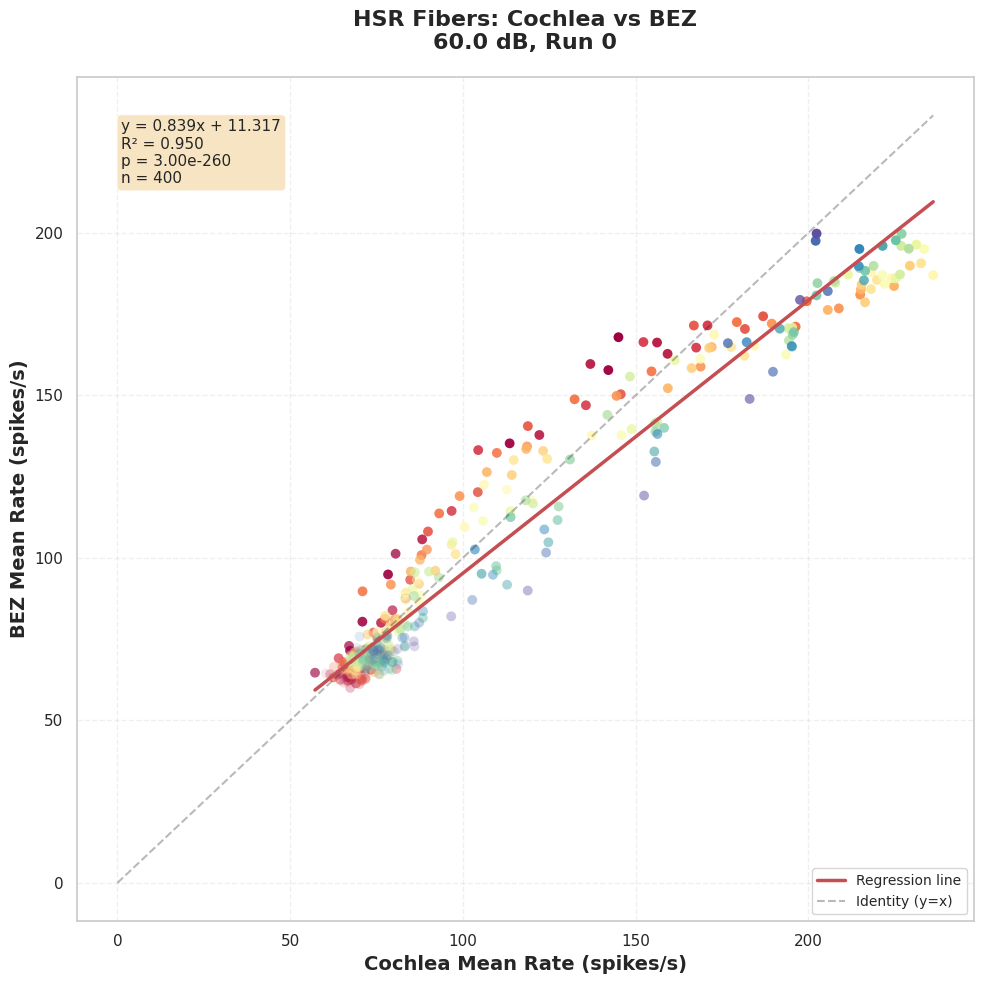

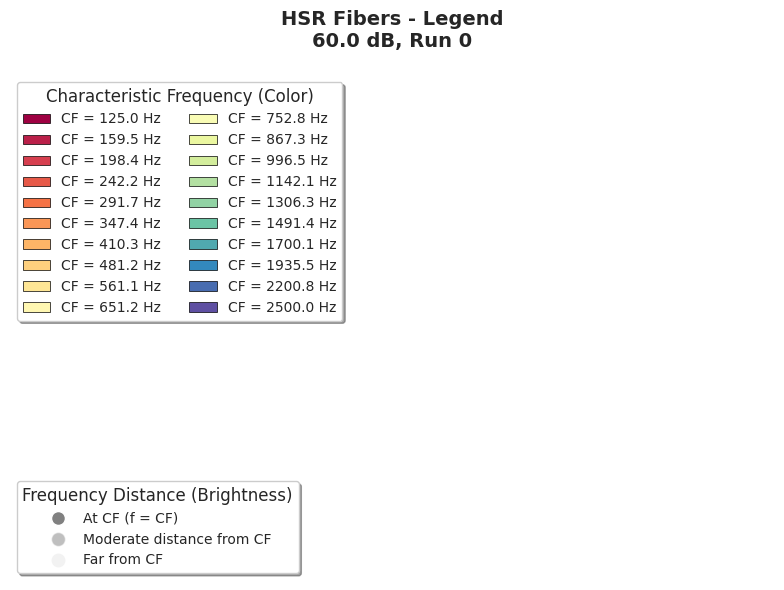


HSR Statistics at 60.0 dB:
  Slope: 0.8395 ± 0.0097
  R²: 0.9496
  p-value: 3.00e-260
  N points: 400


In [ ]:
# Plot HSR fibers
print("Creating HSR plot with complete CF legend...")

fig_hsr, ax_hsr, legend_hsr, stats_hsr = plot_single_fiber_cf_brightness(
    cochlea_means, 
    bez_means, 
    fiber_type='hsr',
    run_idx=selected_run,
    db_level=selected_db,
    figsize=(10, 10),
    save_path=f'{OUTPUT_DIR}/hsr_regression_cf_brightness_{int(selected_db)}dB_run{selected_run}.png',
    save_legend_path=f'{OUTPUT_DIR}/hsr_legend_{int(selected_db)}dB_run{selected_run}.png'
)

plt.show()

# Print statistics
print(f"\nHSR Statistics at {selected_db} dB:")
print(f"  Slope: {stats_hsr['slope']:.4f} ± {stats_hsr['stderr']:.4f}")
print(f"  R²: {stats_hsr['r_squared']:.4f}")
print(f"  p-value: {stats_hsr['p_value']:.2e}")
print(f"  N points: {stats_hsr['n_points']}")

### Plot MSR Fibers with Complete CF Legend

Creating MSR plot with complete CF legend...


/tmp/ipykernel_132523/4240014597.py:100: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_val, b_val, c=cf_colors[cf], alpha=alpha, s=50, edgecolors='none')


Saved plot to msr_regression_cf_brightness_60dB_run0.png
Saved legend to msr_legend_60dB_run0.png


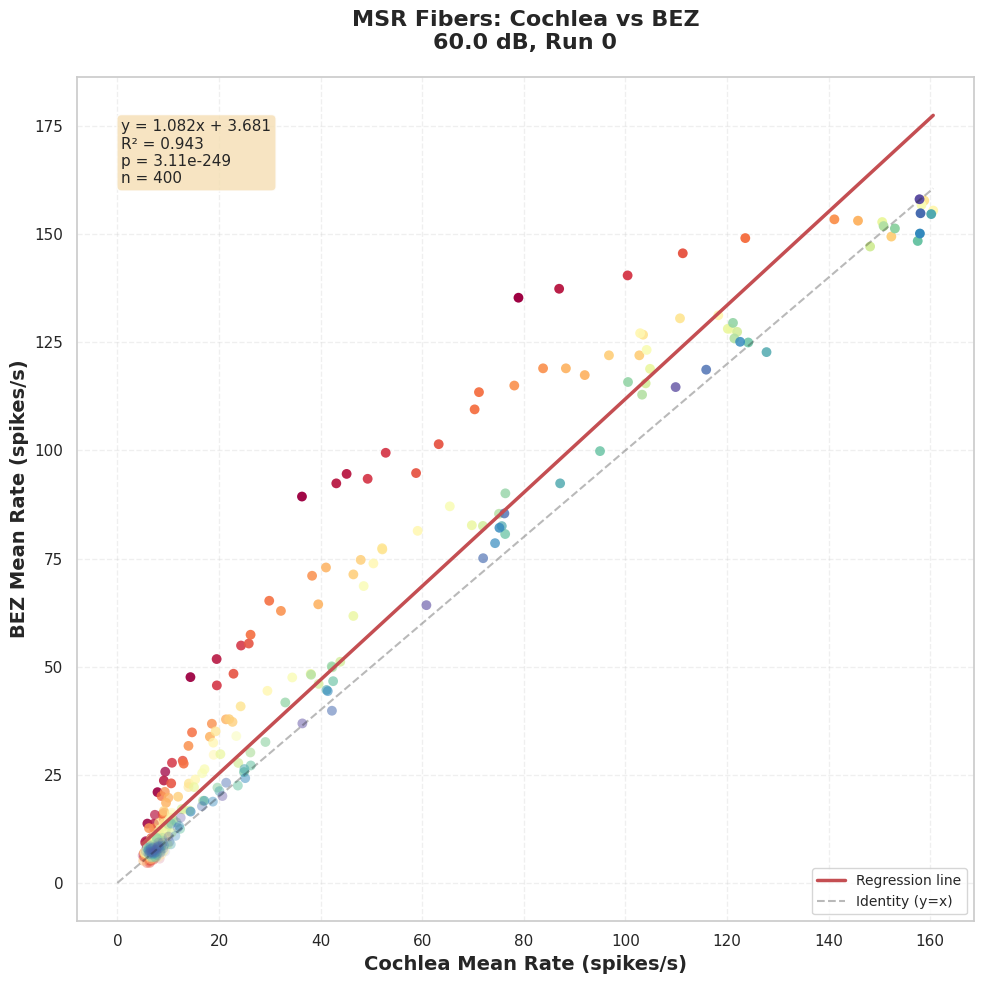

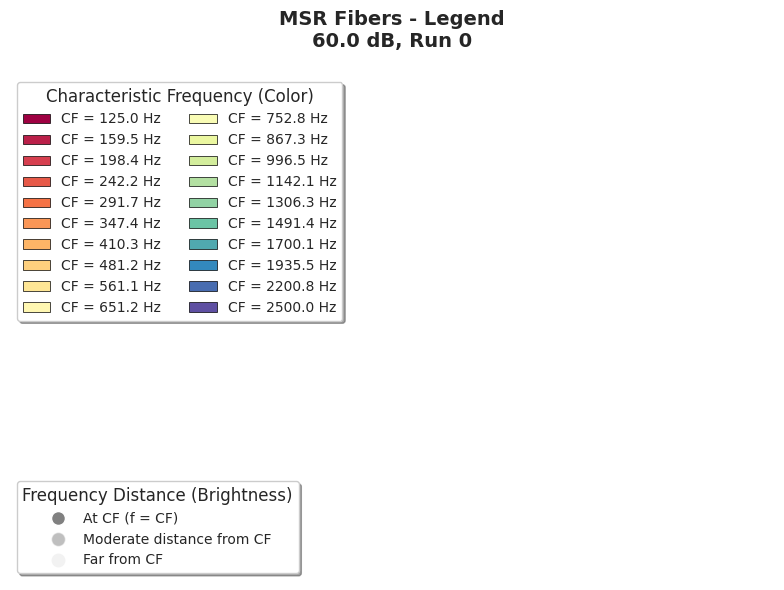


MSR Statistics at 60.0 dB:
  Slope: 1.0823 ± 0.0134
  R²: 0.9427
  p-value: 3.11e-249
  N points: 400


In [ ]:
# Plot MSR fibers
print("Creating MSR plot with complete CF legend...")

fig_msr, ax_msr, legend_msr, stats_msr = plot_single_fiber_cf_brightness(
    cochlea_means, 
    bez_means, 
    fiber_type='msr',
    run_idx=selected_run,
    db_level=selected_db,
    figsize=(10, 10),
    save_path=f'{OUTPUT_DIR}/msr_regression_cf_brightness_{int(selected_db)}dB_run{selected_run}.png',
    save_legend_path=f'{OUTPUT_DIR}/msr_legend_{int(selected_db)}dB_run{selected_run}.png'
)

plt.show()

# Print statistics
print(f"\nMSR Statistics at {selected_db} dB:")
print(f"  Slope: {stats_msr['slope']:.4f} ± {stats_msr['stderr']:.4f}")
print(f"  R²: {stats_msr['r_squared']:.4f}")
print(f"  p-value: {stats_msr['p_value']:.2e}")
print(f"  N points: {stats_msr['n_points']}")

### Plot LSR Fibers with Complete CF Legend

Creating LSR plot with complete CF legend...


/tmp/ipykernel_132523/4240014597.py:100: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_val, b_val, c=cf_colors[cf], alpha=alpha, s=50, edgecolors='none')


Saved plot to lsr_regression_cf_brightness_60dB_run0.png
Saved legend to lsr_legend_60dB_run0.png


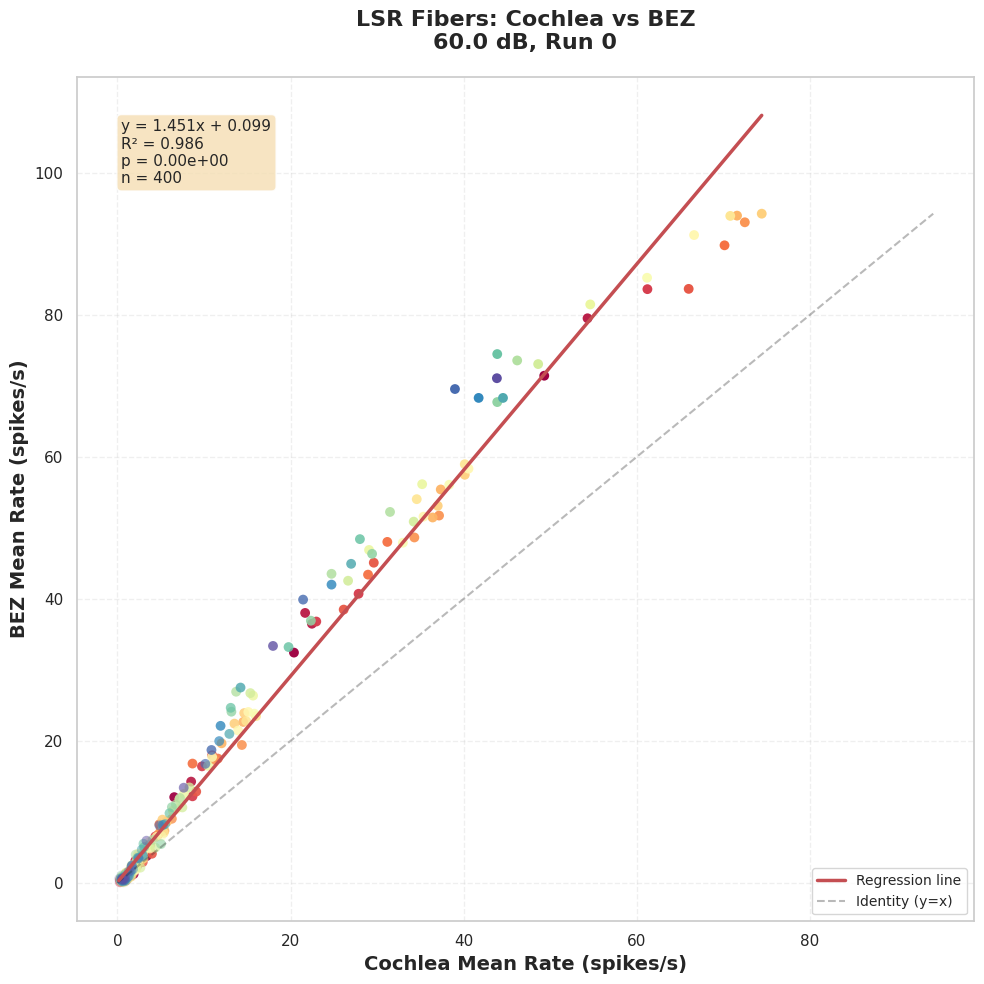

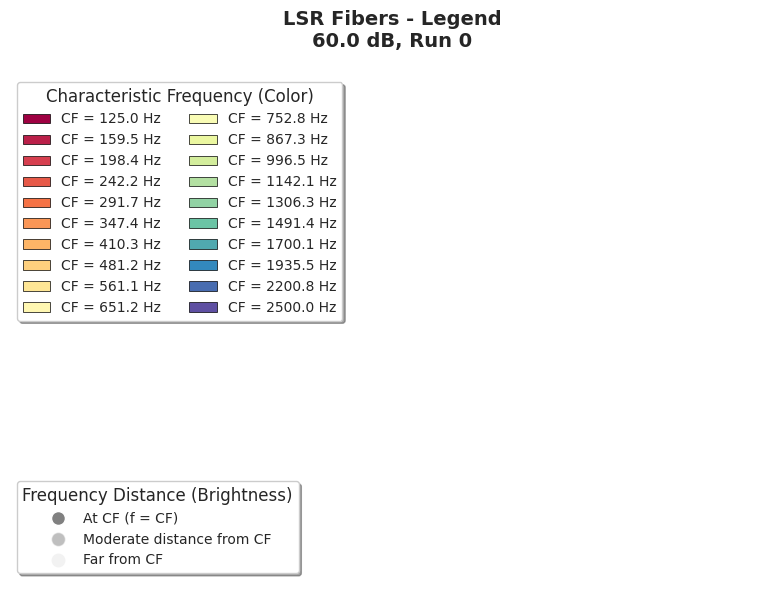


LSR Statistics at 60.0 dB:
  Slope: 1.4509 ± 0.0086
  R²: 0.9863
  p-value: 0.00e+00
  N points: 400


In [ ]:
# Plot LSR fibers
print("Creating LSR plot with complete CF legend...")

fig_lsr, ax_lsr, legend_lsr, stats_lsr = plot_single_fiber_cf_brightness(
    cochlea_means, 
    bez_means, 
    fiber_type='lsr',
    run_idx=selected_run,
    db_level=selected_db,
    figsize=(10, 10),
    save_path=f'{OUTPUT_DIR}/lsr_regression_cf_brightness_{int(selected_db)}dB_run{selected_run}.png',
    save_legend_path=f'{OUTPUT_DIR}/lsr_legend_{int(selected_db)}dB_run{selected_run}.png'
)

plt.show()

# Print statistics
print(f"\nLSR Statistics at {selected_db} dB:")
print(f"  Slope: {stats_lsr['slope']:.4f} ± {stats_lsr['stderr']:.4f}")
print(f"  R²: {stats_lsr['r_squared']:.4f}")
print(f"  p-value: {stats_lsr['p_value']:.2e}")
print(f"  N points: {stats_lsr['n_points']}")

### Summary: Compare All Fiber Types (Individual Plots)

In [ ]:
# Summary comparison of individual fiber plots
print(f"\n{'='*80}")
print(f"SUMMARY: Individual Fiber Plots at {selected_db} dB (Run {selected_run})")
print('='*80)
print(f"{'Fiber':<8} {'Slope':<12} {'R²':<10} {'p-value':<12} {'N points'}")
print('-'*80)

for fiber_name, stats in [('HSR', stats_hsr), ('MSR', stats_msr), ('LSR', stats_lsr)]:
    print(f"{fiber_name:<8} {stats['slope']:<12.4f} {stats['r_squared']:<10.4f} "
          f"{stats['p_value']:<12.2e} {stats['n_points']}")

print('='*80)

# File outputs
print(f"\n✓ Saved 6 files to {OUTPUT_DIR}/:")
print(f"  Main plots:")
print(f"    - hsr_regression_cf_brightness_{int(selected_db)}dB_run{selected_run}.png")
print(f"    - msr_regression_cf_brightness_{int(selected_db)}dB_run{selected_run}.png")
print(f"    - lsr_regression_cf_brightness_{int(selected_db)}dB_run{selected_run}.png")
print(f"  Legends (with ALL CF values):")
print(f"    - hsr_legend_{int(selected_db)}dB_run{selected_run}.png")
print(f"    - msr_legend_{int(selected_db)}dB_run{selected_run}.png")
print(f"    - lsr_legend_{int(selected_db)}dB_run{selected_run}.png")


SUMMARY: Individual Fiber Plots at 60.0 dB (Run 0)
Fiber    Slope        R²         p-value      N points
--------------------------------------------------------------------------------
HSR      0.8395       0.9496     3.00e-260    400
MSR      1.0823       0.9427     3.11e-249    400
LSR      1.4509       0.9863     0.00e+00     400

✓ Saved 6 files:
  Main plots:
    - hsr_regression_cf_brightness_60dB_run0.png
    - msr_regression_cf_brightness_60dB_run0.png
    - lsr_regression_cf_brightness_60dB_run0.png
  Legends (with ALL CF values):
    - hsr_legend_60dB_run0.png
    - msr_legend_60dB_run0.png
    - lsr_legend_60dB_run0.png


# BEZ Run Correlation Analysis

Assess whether BEZ runs are similar enough to justify averaging by comparing:
1. **BEZ run-to-run correlations**: How consistent are individual BEZ runs with each other?
2. **Cochlea-BEZ correlations**: How well does Cochlea agree with each BEZ run?

This helps determine if the variability between BEZ runs is smaller than the difference between Cochlea and BEZ.

## Step 1: Compute BEZ Run Pair-wise Correlations

Calculate Pearson correlation between all pairs of BEZ runs (e.g., run 0 vs run 1, run 0 vs run 2, etc.)

In [12]:
# Compute pair-wise correlations between all BEZ runs at selected dB level
print(f"Computing BEZ run pair-wise correlations at {selected_db} dB...")
print("=" * 70)

bez_pairwise = compute_bez_run_pairwise_correlations(
    bez_means, 
    db_level=selected_db,
    fiber_types=['hsr', 'msr', 'lsr']
)

# Display results for each fiber type
for fiber in ['hsr', 'msr', 'lsr']:
    print(f"\n{fiber.upper()} Fibers:")
    print("-" * 70)
    
    # Show first few run pairs as examples
    run_pairs = sorted(bez_pairwise[fiber].keys())
    print(f"  Showing first 5 run pairs (out of {len(run_pairs)} total):")
    
    for pair in run_pairs[:5]:
        r = bez_pairwise[fiber][pair]['r']
        p = bez_pairwise[fiber][pair]['p']
        n = bez_pairwise[fiber][pair]['n']
        print(f"    Run {pair[0]} vs Run {pair[1]}: r = {r:.4f}, p = {p:.2e}, n = {n}")
    
    # Summary statistics
    summary = bez_pairwise['summary'][fiber]
    print(f"\n  Summary across all {summary['n_pairs']} run pairs:")
    print(f"    Mean correlation:  {summary['mean']:.4f}")
    print(f"    Std deviation:     {summary['std']:.4f}")
    print(f"    Range:             {summary['min']:.4f} - {summary['max']:.4f}")

print("\n" + "=" * 70)
print("✓ BEZ pair-wise correlations computed")

Computing BEZ run pair-wise correlations at 60.0 dB...

HSR Fibers:
----------------------------------------------------------------------
  Showing first 5 run pairs (out of 45 total):
    Run 0 vs Run 1: r = 0.9988, p = 0.00e+00, n = 400
    Run 0 vs Run 2: r = 0.9988, p = 0.00e+00, n = 400
    Run 0 vs Run 3: r = 0.9989, p = 0.00e+00, n = 400
    Run 0 vs Run 4: r = 0.9989, p = 0.00e+00, n = 400
    Run 0 vs Run 5: r = 0.9989, p = 0.00e+00, n = 400

  Summary across all 45 run pairs:
    Mean correlation:  0.9989
    Std deviation:     0.0001
    Range:             0.9987 - 0.9990

MSR Fibers:
----------------------------------------------------------------------
  Showing first 5 run pairs (out of 45 total):
    Run 0 vs Run 1: r = 0.9996, p = 0.00e+00, n = 400
    Run 0 vs Run 2: r = 0.9995, p = 0.00e+00, n = 400
    Run 0 vs Run 3: r = 0.9995, p = 0.00e+00, n = 400
    Run 0 vs Run 4: r = 0.9996, p = 0.00e+00, n = 400
    Run 0 vs Run 5: r = 0.9995, p = 0.00e+00, n = 400

  Summa

## Step 2: Compute Cochlea vs Individual BEZ Run Correlations

Calculate correlation between Cochlea and each individual BEZ run

In [13]:
# Compute correlations between Cochlea and each BEZ run
print(f"Computing Cochlea vs BEZ run correlations at {selected_db} dB...")
print("=" * 70)

cochlea_bez_corrs = compute_cochlea_vs_bez_runs_correlations(
    cochlea_means,
    bez_means,
    db_level=selected_db,
    fiber_types=['hsr', 'msr', 'lsr']
)

# Display results for each fiber type
for fiber in ['hsr', 'msr', 'lsr']:
    print(f"\n{fiber.upper()} Fibers:")
    print("-" * 70)
    
    # Show correlation for each run
    for run_idx in sorted(cochlea_bez_corrs[fiber].keys()):
        r = cochlea_bez_corrs[fiber][run_idx]['r']
        p = cochlea_bez_corrs[fiber][run_idx]['p']
        n = cochlea_bez_corrs[fiber][run_idx]['n']
        print(f"  Cochlea vs BEZ Run {run_idx}: r = {r:.4f}, p = {p:.2e}, n = {n}")
    
    # Summary statistics
    summary = cochlea_bez_corrs['summary'][fiber]
    print(f"\n  Summary across {summary['n_runs']} runs:")
    print(f"    Mean correlation:  {summary['mean']:.4f}")
    print(f"    Std deviation:     {summary['std']:.4f}")
    print(f"    Range:             {summary['min']:.4f} - {summary['max']:.4f}")

print("\n" + "=" * 70)
print("✓ Cochlea-BEZ correlations computed")

Computing Cochlea vs BEZ run correlations at 60.0 dB...

HSR Fibers:
----------------------------------------------------------------------
  Cochlea vs BEZ Run 0: r = 0.9745, p = 3.00e-260, n = 400
  Cochlea vs BEZ Run 1: r = 0.9758, p = 9.29e-265, n = 400
  Cochlea vs BEZ Run 2: r = 0.9757, p = 1.24e-264, n = 400
  Cochlea vs BEZ Run 3: r = 0.9751, p = 1.63e-262, n = 400
  Cochlea vs BEZ Run 4: r = 0.9749, p = 9.95e-262, n = 400
  Cochlea vs BEZ Run 5: r = 0.9750, p = 5.60e-262, n = 400
  Cochlea vs BEZ Run 6: r = 0.9750, p = 5.32e-262, n = 400
  Cochlea vs BEZ Run 7: r = 0.9753, p = 3.63e-263, n = 400
  Cochlea vs BEZ Run 8: r = 0.9750, p = 5.16e-262, n = 400
  Cochlea vs BEZ Run 9: r = 0.9754, p = 1.24e-263, n = 400

  Summary across 10 runs:
    Mean correlation:  0.9752
    Std deviation:     0.0004
    Range:             0.9745 - 0.9758

MSR Fibers:
----------------------------------------------------------------------
  Cochlea vs BEZ Run 0: r = 0.9709, p = 3.11e-249, n = 400
 

## Step 3: Compare BEZ Run-to-Run vs Cochlea-BEZ Correlations

Visualize the comparison to assess if BEZ runs are more similar to each other than to Cochlea

Creating correlation comparison plot at 60.0 dB...
✓ Correlation comparison saved to: correlation_comparison_60dB.png
✓ Correlation comparison saved to: correlation_comparison_60dB.png


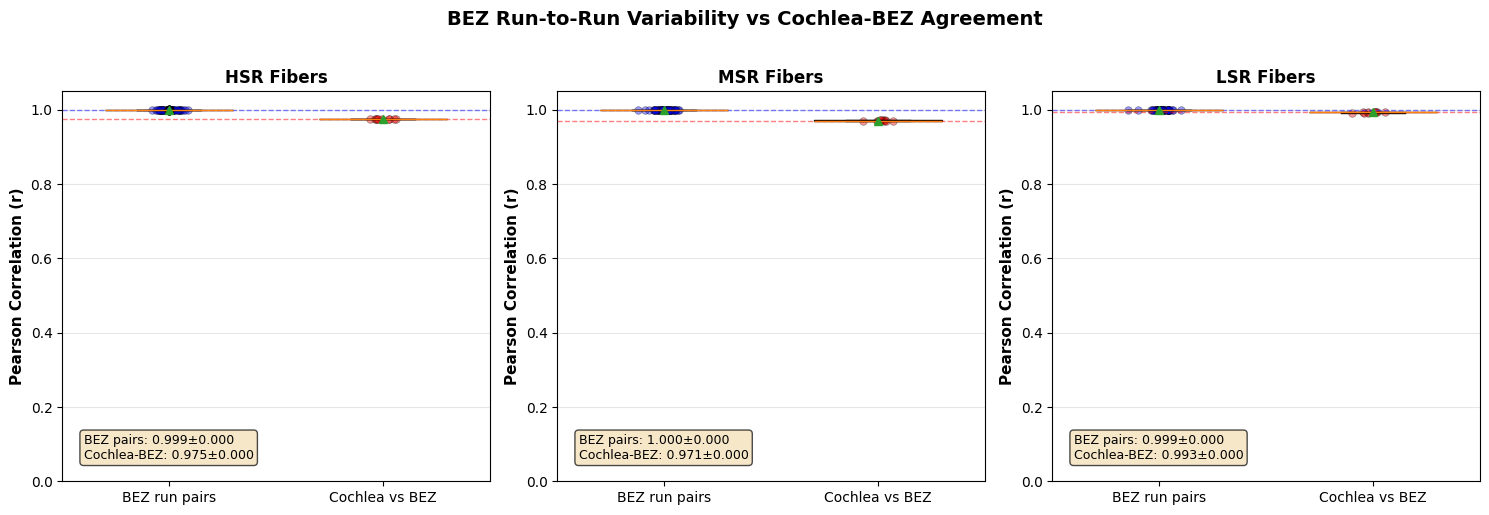


✓ Correlation comparison plot created


In [ ]:
# Create comparison visualization
print(f"Creating correlation comparison plot at {selected_db} dB...")

fig_corr, axes_corr = plot_correlation_comparison(
    bez_pairwise,
    cochlea_bez_corrs,
    fiber_types=['hsr', 'msr', 'lsr'],
    save_path=f'{OUTPUT_DIR}/correlation_comparison_{int(selected_db)}dB.png',
    figsize=(15, 5)
)

plt.show()

print("\n✓ Correlation comparison plot created")

# Save correlation statistics to JSON, text, and LaTeX files
output_files = save_correlation_statistics(
    bez_pairwise,
    cochlea_bez_corrs,
    db_level=selected_db,
    output_dir=OUTPUT_DIR
)

## Step 4: Interpretation and Summary

In [15]:
# Summary comparison table
print(f"\n{'='*90}")
print(f"CORRELATION COMPARISON SUMMARY at {selected_db} dB")
print('='*90)
print(f"{'Fiber':<8} {'BEZ run pairs':<25} {'Cochlea vs BEZ':<25} {'Interpretation'}")
print(f"{'Type':<8} {'(mean ± std)':<25} {'(mean ± std)':<25}")
print('-'*90)

for fiber in ['hsr', 'msr', 'lsr']:
    bez_mean = bez_pairwise['summary'][fiber]['mean']
    bez_std = bez_pairwise['summary'][fiber]['std']
    
    coch_mean = cochlea_bez_corrs['summary'][fiber]['mean']
    coch_std = cochlea_bez_corrs['summary'][fiber]['std']
    
    # Determine interpretation
    if bez_mean > coch_mean:
        diff = bez_mean - coch_mean
        if diff > 0.1:
            interp = "✓ Runs highly consistent"
        elif diff > 0.05:
            interp = "✓ Runs more consistent"
        else:
            interp = "Similar consistency"
    else:
        interp = "⚠ Cochlea closer to BEZ"
    
    print(f"{fiber.upper():<8} {bez_mean:.3f} ± {bez_std:.3f}          "
          f"{coch_mean:.3f} ± {coch_std:.3f}          {interp}")

print('='*90)

print("\n📊 Interpretation Guide:")
print("  • If BEZ run pairs >> Cochlea-BEZ: BEZ runs are very consistent; averaging is justified")
print("  • If BEZ run pairs ≈ Cochlea-BEZ: BEZ variability similar to Cochlea difference")
print("  • If BEZ run pairs < Cochlea-BEZ: BEZ runs vary more than Cochlea-BEZ difference")
print("\n💡 Decision:")
print("  • High BEZ run correlation (>0.9): Averaging across runs is strongly justified")
print("  • Moderate correlation (0.7-0.9): Averaging is reasonable; consider run variability")
print("  • Low correlation (<0.7): Investigate run-specific effects before averaging")


CORRELATION COMPARISON SUMMARY at 60.0 dB
Fiber    BEZ run pairs             Cochlea vs BEZ            Interpretation
Type     (mean ± std)              (mean ± std)             
------------------------------------------------------------------------------------------
HSR      0.999 ± 0.000          0.975 ± 0.000          Similar consistency
MSR      1.000 ± 0.000          0.971 ± 0.000          Similar consistency
LSR      0.999 ± 0.000          0.993 ± 0.000          Similar consistency

📊 Interpretation Guide:
  • If BEZ run pairs >> Cochlea-BEZ: BEZ runs are very consistent; averaging is justified
  • If BEZ run pairs ≈ Cochlea-BEZ: BEZ variability similar to Cochlea difference
  • If BEZ run pairs < Cochlea-BEZ: BEZ runs vary more than Cochlea-BEZ difference

💡 Decision:
  • High BEZ run correlation (>0.9): Averaging across runs is strongly justified
  • Moderate correlation (0.7-0.9): Averaging is reasonable; consider run variability
  • Low correlation (<0.7): Investigate run-

## Step 5: Review Saved Files

All results are saved to the output directory for later use in LaTeX documents

In [ ]:
# List all files saved in the output directory
from pathlib import Path
import os

print(f"\n{'='*90}")
print(f"FILES SAVED TO: {OUTPUT_DIR}/")
print('='*90)

output_path = Path(OUTPUT_DIR)
if output_path.exists():
    files = sorted(output_path.glob('*'))
    
    # Group files by type
    plots = [f for f in files if f.suffix == '.png']
    pdfs = [f for f in files if f.suffix == '.pdf']
    json_files = [f for f in files if f.suffix == '.json']
    txt_files = [f for f in files if f.suffix == '.txt']
    tex_files = [f for f in files if f.suffix == '.tex']
    
    print(f"\n📊 PLOTS ({len(plots)} files):")
    for f in plots:
        size_mb = f.stat().st_size / 1024 / 1024
        print(f"  - {f.name} ({size_mb:.2f} MB)")
    
    if pdfs:
        print(f"\n📄 PDF PLOTS ({len(pdfs)} files):")
        for f in pdfs:
            size_mb = f.stat().st_size / 1024 / 1024
            print(f"  - {f.name} ({size_mb:.2f} MB)")
    
    print(f"\n📈 STATISTICS FOR LATEX ({len(json_files) + len(txt_files) + len(tex_files)} files):")
    if json_files:
        print(f"  JSON files ({len(json_files)}):")
        for f in json_files:
            print(f"    - {f.name}")
    if txt_files:
        print(f"  Text files ({len(txt_files)}):")
        for f in txt_files:
            print(f"    - {f.name}")
    if tex_files:
        print(f"  LaTeX tables ({len(tex_files)}):")
        for f in tex_files:
            print(f"    - {f.name}")
    
    print(f"\n📁 Total: {len(files)} files")
    total_size = sum(f.stat().st_size for f in files) / 1024 / 1024
    print(f"💾 Total size: {total_size:.2f} MB")
    
    print("\n💡 Usage Tips:")
    print("  • JSON files: Machine-readable data for further analysis")
    print("  • TXT files: Human-readable summary for quick reference")
    print("  • TEX files: Ready-to-use LaTeX tables for your manuscript")
    print("  • PNG files: High-resolution plots (300 DPI) for presentations")
    print("  • PDF files: Vector graphics for publications")
    
else:
    print(f"⚠️ Directory {OUTPUT_DIR}/ does not exist yet")

print('='*90)

## Optional: Analyze Across All dB Levels

Compare BEZ run consistency across different intensity levels

In [ ]:
# Analyze BEZ run consistency across all dB levels
print("Analyzing BEZ run correlations across ALL dB levels...")
print("=" * 90)

# Compute for all dB levels (no db_level specified)
bez_pairwise_all_db = compute_bez_run_pairwise_correlations(
    bez_means,
    db_level=None,  # Analyze all dB levels
    fiber_types=['hsr', 'msr', 'lsr']
)

# Create summary table
print(f"\n{'='*90}")
print("BEZ RUN-TO-RUN CORRELATIONS ACROSS dB LEVELS")
print('='*90)
print(f"{'dB Level':<12} {'HSR Mean r':<15} {'MSR Mean r':<15} {'LSR Mean r':<15}")
print('-'*90)

for db in sorted(params['dbs']):
    hsr_mean = bez_pairwise_all_db['summary']['hsr'][db]['mean']
    msr_mean = bez_pairwise_all_db['summary']['msr'][db]['mean']
    lsr_mean = bez_pairwise_all_db['summary']['lsr'][db]['mean']
    
    print(f"{db:<12.1f} {hsr_mean:<15.4f} {msr_mean:<15.4f} {lsr_mean:<15.4f}")

print('='*90)

# Compute Cochlea vs BEZ for all dB levels
print("\nComputing Cochlea-BEZ correlations for all dB levels...")

cochlea_bez_all_db = {}
for db in params['dbs']:
    cochlea_bez_all_db[db] = compute_cochlea_vs_bez_runs_correlations(
        cochlea_means, bez_means, db_level=db
    )

# Summary table
print(f"\n{'='*90}")
print("COCHLEA vs BEZ CORRELATIONS ACROSS dB LEVELS")
print('='*90)
print(f"{'dB Level':<12} {'HSR Mean r':<15} {'MSR Mean r':<15} {'LSR Mean r':<15}")
print('-'*90)

for db in sorted(params['dbs']):
    hsr_mean = cochlea_bez_all_db[db]['summary']['hsr']['mean']
    msr_mean = cochlea_bez_all_db[db]['summary']['msr']['mean']
    lsr_mean = cochlea_bez_all_db[db]['summary']['lsr']['mean']
    
    print(f"{db:<12.1f} {hsr_mean:<15.4f} {msr_mean:<15.4f} {lsr_mean:<15.4f}")

print('='*90)

# Final comparison
print(f"\n{'='*90}")
print("OVERALL COMPARISON: BEZ Consistency vs Cochlea Agreement")
print('='*90)

for fiber in ['hsr', 'msr', 'lsr']:
    print(f"\n{fiber.upper()} Fibers:")
    print("-" * 90)
    
    for db in sorted(params['dbs']):
        bez_r = bez_pairwise_all_db['summary'][fiber][db]['mean']
        coch_r = cochlea_bez_all_db[db]['summary'][fiber]['mean']
        diff = bez_r - coch_r
        
        if diff > 0.1:
            status = "✓✓ Highly consistent runs"
        elif diff > 0.05:
            status = "✓ Runs more consistent"
        elif diff > -0.05:
            status = "≈ Similar"
        else:
            status = "⚠ Cochlea closer"
        
        print(f"  {db} dB: BEZ={bez_r:.3f}, Cochlea={coch_r:.3f}, Diff={diff:+.3f} → {status}")

print("\n" + "=" * 90)

### Interpretation Guide

**Color Encoding (Hue):**
- Each characteristic frequency (CF) has a unique color from a perceptually uniform palette
- Same color across all three panels = same CF population
- Spectral colormap ensures distinct, distinguishable colors

**Brightness Encoding (Alpha):**
- **Bright points** (alpha = 1.0): Stimulus frequency equals CF (f = CF)
- **Medium brightness** (alpha ~ 0.5): Stimulus frequency moderately far from CF
- **Dim points** (alpha = 0.1): Stimulus frequency far from CF

**What to Look For:**
- **Bright points near regression line**: Good model agreement at best frequency
- **Scatter in dim points**: Models differ in off-CF responses
- **Color clustering**: Some CFs may show systematically different relationships
- **Slope differences across fiber types**: Reveals fiber-specific encoding differences

### Optional: Compare Across Multiple dB Levels with Advanced Plots

In [ ]:
# Create seaborn plots for each dB level
seaborn_stats_all_db = {}

for db_level in params['dbs']:
    print(f"\n{'='*70}")
    print(f"Creating advanced plot for {db_level} dB")
    print('='*70)
    
    fig, axes, stats = plot_regression_seaborn_cf_brightness(
        cochlea_means,
        bez_means,
        run_idx=selected_run,
        db_level=db_level,
        figsize=(18, 8),
        save_path=f'regression_seaborn_{int(db_level)}dB_run{selected_run}.png'
    )
    
    seaborn_stats_all_db[db_level] = stats
    
    plt.show()

# Summary comparison
print(f"\n\n{'='*80}")
print("SUMMARY: Slopes from Seaborn Plots Across dB Levels")
print('='*80)
print(f"{'dB Level':<12} {'HSR Slope':<15} {'MSR Slope':<15} {'LSR Slope':<15}")
print('-'*80)
for db_level in sorted(seaborn_stats_all_db.keys()):
    hsr_slope = seaborn_stats_all_db[db_level]['hsr']['slope']
    msr_slope = seaborn_stats_all_db[db_level]['msr']['slope']
    lsr_slope = seaborn_stats_all_db[db_level]['lsr']['slope']
    print(f"{db_level:<12.1f} {hsr_slope:<15.4f} {msr_slope:<15.4f} {lsr_slope:<15.4f}")
print('='*80)

# R² comparison
print(f"\n{'='*80}")
print("SUMMARY: R² Values from Seaborn Plots Across dB Levels")
print('='*80)
print(f"{'dB Level':<12} {'HSR R²':<15} {'MSR R²':<15} {'LSR R²':<15}")
print('-'*80)
for db_level in sorted(seaborn_stats_all_db.keys()):
    hsr_r2 = seaborn_stats_all_db[db_level]['hsr']['r_squared']
    msr_r2 = seaborn_stats_all_db[db_level]['msr']['r_squared']
    lsr_r2 = seaborn_stats_all_db[db_level]['lsr']['r_squared']
    print(f"{db_level:<12.1f} {hsr_r2:<15.4f} {msr_r2:<15.4f} {lsr_r2:<15.4f}")
print('='*80)